In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math 
import seaborn as sns

# Global variables
print("Configuration")
#path_root = "C:\\Users\\annaw\\Documents\\GitHub\\ideal_diet\\src\\"
path_root = "G:\\CIAT\\Code\\CWR\\ideal_diet\\src\\"
path_inputs = path_root +"inputs\\"
path_outputs = path_root + "outputs\\"

print("\tSetting parameters")
fao_element = [645,664]
#proportion = True
proportion = False

print("\tLoading parameters")
groups = pd.read_excel(path_inputs + "configurations.xlsx", sheet_name='groups')
if (proportion):
    diets = pd.read_excel(path_inputs + "configurations.xlsx", sheet_name='diets_proportion')
else: 
    diets = pd.read_excel(path_inputs + "configurations.xlsx", sheet_name='diets')
years = pd.read_excel(path_inputs + "configurations.xlsx", sheet_name='years')
indicators_country = pd.read_excel(path_inputs + "configurations.xlsx", sheet_name='indicators_country')

print("\tOther things")
years_fao_colnames = ["Y"+str(y.year) for y in years.itertuples(index=True, name='Pandas')]

print("\tSuccessful")

Configuration
	Setting parameters
	Loading parameters
	Other things
	Successful


In [2]:
print("Merging fao data with groups")

print("\tLoading fao data")
data_fao = pd.read_csv(path_inputs + "faostat-food_supply.csv", encoding = "ISO-8859-1")

print("\tMerging fao data with groups")
data_fao_groups = pd.merge(data_fao, groups, left_on = "Item Code",right_on="Item Code",how='inner')

print("\tFiltering columns")
data_fao_colnames = ["ID","Area Code","Area","Item Code","Item_x","Element Code","Element","Unit","Description","Food group"]
data_fao_colnames.extend(years_fao_colnames)
data_fao_groups = data_fao_groups[data_fao_colnames]
data_fao_groups_colnames = ["id","area_code","area","item_code","item","element_code","element","unit","description","food_group"]
data_fao_groups_colnames.extend(years_fao_colnames)
data_fao_groups.columns = data_fao_groups_colnames

print("\tFiltering element " + str(fao_element))
data_fao_groups = data_fao_groups[data_fao_groups.element_code.isin(fao_element)]

print("\tPivoting food groups")
data_fao_groups = pd.pivot_table(data_fao_groups, values=years_fao_colnames, index=['area','food_group'], columns=['element_code'], aggfunc=np.sum,fill_value=0.0)    
data_fao_groups.reset_index(inplace=True)
data_fao_groups.columns = data_fao_groups.columns.droplevel()
data_fao_groups_colnames = ['area','food_group']
for y in years_fao_colnames:
    for e in fao_element:
        data_fao_groups_colnames.append(y + "_" + str(e))
data_fao_groups.columns = data_fao_groups_colnames

print("\tSaving")
data_fao_groups.to_excel(path_outputs +'1-data_fao_groups.xlsx', engine='openpyxl', index = False)

print("\tSuccessful")

Merging fao data with groups
	Loading fao data
	Merging fao data with groups
	Filtering columns
	Filtering element [645, 664]
	Pivoting food groups
	Saving
	Successful


In [17]:
print("Merging fao data with diets and ssr")

print("\tLoading and merging SSR data")
# REMEMBER: You should execute ssr analysis before and put into inputs folder like csv file and just leave the columns
# with ssr results for each variable
ssr = pd.read_csv(path_inputs + "ssr.csv", encoding = "ISO-8859-1")
data_fao_diet = pd.merge(data_fao_groups, ssr, left_on = ["area","food_group"],right_on=["area","food_group"],how='inner')

# added a new year column name for comparing ssr analysis
years_fao_colnames.append("ssr")    

if(proportion):
    prop = data_fao_diet.groupby(['area']).sum()

    data_fao_diet = pd.merge(data_fao_diet, prop, left_on = "area",right_on="area",how='inner')

    for y in years_fao_colnames:
        for e in fao_element:
            data_fao_diet[y+"_"+str(e)]=data_fao_diet[y+"_"+str(e)+"_x"]/data_fao_diet[y+"_"+str(e)+"_y"]


    reg_exp = "^(" + "|".join(years_fao_colnames) + ")_([A-Za-z])*(\d)*_(" + "|".join(["x","y"]) + ")"
    cols = data_fao_diet.columns.drop(list(data_fao_diet.filter(regex=reg_exp)))

    data_fao_diet = data_fao_diet[cols]

print("\tMerging fao data with diet")
data_fao_diet = pd.merge(data_fao_diet, diets, left_on = "food_group",right_on="food_group",how='inner')

print("\tSaving")
data_fao_diet.to_excel(path_outputs +'2-data_fao_diet.xlsx', engine='openpyxl', index = False)

print("\tSuccessful")

Merging fao data with diets and ssr
	Loading and merging SSR data
	Merging fao data with diet
	Saving
	Successful


In [21]:
print("Calculating categories")

print("\tCreating categories fields")
data_fao_cat = data_fao_diet.copy()

for y in years_fao_colnames:
    for e in fao_element:
        data_fao_cat["category_" + y + "_" + str(e)] = 0

print("\tGetting food groups")
food_group = data_fao_cat.food_group.unique()


quintals = pd.DataFrame()


def above(x,q1):    
    y = -1
    if x<=q1[0]:
        y = 1
    elif (x>q1[0] and x<=q1[1]):
        y = 2 
    elif (x>q1[1] and x<=q1[2]):
        y = 3 
    else:
        y = 4
    #print(str(x) + " " + str(y) + " " + str(q1))
    return y

def below(x,q1):    
    y = -1
    if x>=q1[2]:
        y = 1
    elif (x<q1[2] and x>=q1[1]):
        y = 2
    elif (x<q1[1] and x>=q1[0]):
        y = 3
    else:
        y = 4
    #print(str(x) + " " + str(y) + " " + str(q1))
    return y
    

for e in fao_element:
    print("\tCalculating element: " + str(e))
    diet = "d" + str(e)
        
    for y in years_fao_colnames:
        print("\t\tCalculating year: " + y)
        colname =  y + "_" + str(e)             
        
        for fg in food_group:
            print("\t\t\tCalculating food group: " + fg)
            fg_fao = data_fao_cat[data_fao_cat.food_group == fg]


            # Food groups above
            fg_fao_a = fg_fao[fg_fao.type == "A"] 
            if(fg_fao_a.shape[0]>0):
                # Splitting in two datasets: above or below of diet
                fg_fao_a_above = fg_fao_a[fg_fao_a[colname] >= fg_fao_a[diet]]
                fg_fao_a_below = fg_fao_a[fg_fao_a[colname] < fg_fao_a[diet]]
                

                # Calculating quintals for below data
                q = fg_fao_a_below[colname].quantile([0.25, 0.5, 0.75])
                q["year"] = y.replace("Y","")            
                q["food_group"] = fg
                q["type"] = "A"
                q["element"] = e
                quintals = quintals.append(q, ignore_index=True)
                
                # Setting category A
                data_fao_cat["category_" + y + "_" + str(e)].iloc[fg_fao_a_above.index] = 5                
                fg_fao_a_below["category_" + y + "_" + str(e)] = fg_fao_a_below[colname].apply(lambda x: above(x, q.values))
                data_fao_cat["category_" + y + "_" + str(e)].iloc[fg_fao_a_below.index] = fg_fao_a_below["category_" + y + "_" + str(e)]

            # Food groups below
            fg_fao_b = fg_fao[fg_fao.type == "B"] 
            if(fg_fao_b.shape[0]>0):
                # Splitting in two datasets: above or below of diet
                fg_fao_b_below = fg_fao_b[fg_fao_b[colname] <= fg_fao_b[diet]]
                fg_fao_b_above = fg_fao_b[fg_fao_b[colname] > fg_fao_b[diet]]

                # Calculating quintals for below data
                q = fg_fao_b_above[colname].quantile([0.25, 0.5, 0.75])
                q["year"] = y.replace("Y","")            
                q["food_group"] = fg
                q["type"] = "B"
                q["element"] = e
                quintals = quintals.append(q, ignore_index=True)

                # Setting category B
                data_fao_cat["category_" + y + "_" + str(e)].iloc[fg_fao_b_below.index] = 5
                fg_fao_b_above["category_" + y + "_" + str(e)] = fg_fao_b_above[colname].apply(lambda x: below(x, q.values))
                data_fao_cat["category_" + y + "_" + str(e)].iloc[fg_fao_b_above.index] = fg_fao_b_above["category_" + y + "_" + str(e)]

print("\tSaving")
quintals.to_excel(path_outputs +'3-quintals.xlsx', engine='openpyxl', index = False)  
data_fao_cat.to_excel(path_outputs +'3-data_fao_cat.xlsx', engine='openpyxl', index = False)

print("\tSuccessful")

Calculating categories
	Creating categories fields
	Getting food groups
	Calculating element: 645
		Calculating year: Y2013
			Calculating food group: Alcohol


C:\Users\annaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\annaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


			Calculating food group: Dairy
			Calculating food group: Fats & Oils
			Calculating food group: Fruits
			Calculating food group: Grains (Starchy staples)
			Calculating food group: Legumes, Nuts & Seeds
			Calculating food group: Meats
			Calculating food group: Miscellaneous
			Calculating food group: Spices
			Calculating food group: Sugars
			Calculating food group: Vegetables
		Calculating year: ssr
			Calculating food group: Alcohol
			Calculating food group: Dairy
			Calculating food group: Fats & Oils
			Calculating food group: Fruits
			Calculating food group: Grains (Starchy staples)
			Calculating food group: Legumes, Nuts & Seeds
			Calculating food group: Meats
			Calculating food group: Miscellaneous
			Calculating food group: Spices
			Calculating food group: Sugars
			Calculating food group: Vegetables
	Calculating element: 664
		Calculating year: Y2013
			Calculating food group: Alcohol
			Calculating food group: Dairy
			Calculating food group: Fats & Oils
			Calcu

In [22]:
print("Creating matrix for countries analysis")

print("\tPivoting table by country")
data_countries_columns = []
for y in years_fao_colnames:
    for e in fao_element:
        data_countries_columns.append("category_" + y + "_" + str(e))

        

countries_pivot = pd.pivot_table(data_fao_cat, values=data_countries_columns, index=['area'], columns=['type'], aggfunc=np.sum)
countries_pivot_total = countries_pivot.sum(level=0, axis=1)
countries_pivot = countries_pivot.join(countries_pivot_total)
countries_pivot.reset_index(inplace=True)

countries_pivot_colnames = ['area']
countries_pivot_colnames_total = []
for y in years_fao_colnames:
    for e in fao_element:
        for t in ['A','B']:
            countries_pivot_colnames.append(t + "_" + y + "_" + str(e))
        countries_pivot_colnames_total.append("total_" + y + "_" + str(e))

countries_pivot_colnames.extend(countries_pivot_colnames_total)
countries_pivot.columns = countries_pivot_colnames

print("\tSaving")
countries_pivot.to_excel(path_outputs +'4-data_countries.xlsx', engine='openpyxl', index = False)

print("\tSuccessful")

Creating matrix for countries analysis
	Pivoting table by country
	Saving
	Successful


C:\Users\annaw\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [23]:
print("Countries analysis")

print("\tMerging countries with indicators")
countries_indicators = pd.merge(countries_pivot, indicators_country, left_on = "area",right_on="area",how='inner')

print("\tSaving")
countries_indicators.to_excel(path_outputs +'5-countries_indicators.xlsx', engine='openpyxl', index = False)

# Correlation
print("\tCalculating correlation")
countries_indicators_not_na = countries_indicators.dropna(axis = 0, how ='any') 
countries_indicators_not_na.to_excel(path_outputs +'5-countries_indicators_not_na.xlsx', engine='openpyxl', index = False)
countries_correlation = countries_indicators_not_na.corr(method ='pearson')
#countries_correlation.to_excel(path_outputs +'countries_correlation.xlsx', engine='openpyxl', index = False)
def magnify():
    return [dict(selector="th",props=[("font-size", "7pt")]),
            dict(selector="td",props=[('padding', "0em 0em")]),
            dict(selector="th:hover",props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",props=[('max-width', '200px'),('font-size', '12pt')])]

cmap = sns.diverging_palette(5, 250, as_cmap=True)
countries_table_correlation = countries_correlation.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

print("\tSaving")
countries_table_correlation.to_excel(path_outputs +'5-countries_table_correlation.xlsx', engine='openpyxl')

print("\tSuccessful")

Countries analysis
	Merging countries with indicators
	Saving
	Calculating correlation
	Saving
	Successful


Spider analysis
	Sorting data
		Country Afghanistan
		Country Albania
		Country Algeria
		Country Angola
		Country Antigua and Barbuda
		Country Argentina
		Country Armenia
		Country Australia
		Country Austria
		Country Azerbaijan
		Country Bahamas
		Country Bangladesh
		Country Barbados
		Country Belarus
		Country Belgium
		Country Belize
		Country Benin
		Country Bermuda
		Country Bolivia (Plurinational State of)
		Country Bosnia and Herzegovina
		Country Botswana
		Country Brazil
		Country Brunei Darussalam
		Country Bulgaria
		Country Burkina Faso
		Country Cabo Verde
		Country Cambodia
		Country Cameroon
		Country Canada
		Country Central African Republic
		Country Chad
		Country Chile
		Country China
		Country China, Hong Kong SAR
		Country China, Macao SAR
		Country China, Taiwan Province of
		Country China, mainland
		Country Colombia
		Country Congo
		Country Costa Rica
		Country Croatia
		Country Cuba
		Country Cyprus
		Country Czechia
		Country Côte d'Ivoire
		Country Democ

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\annaw\\Documents\\GitHub\\ideal_diet\\src\\outputs\\\\spider\\664-Ecuador.png'

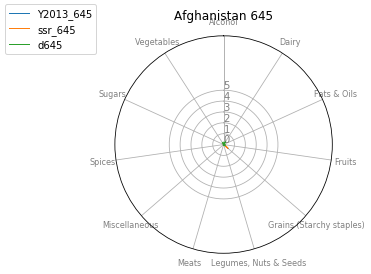

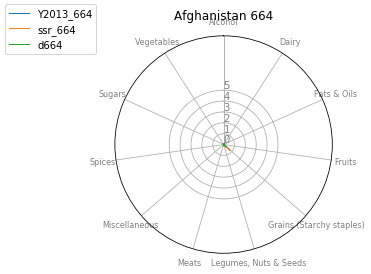

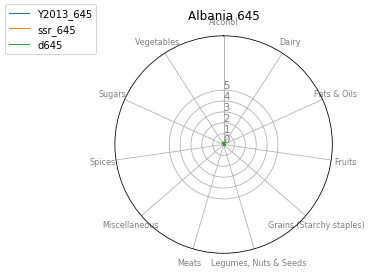

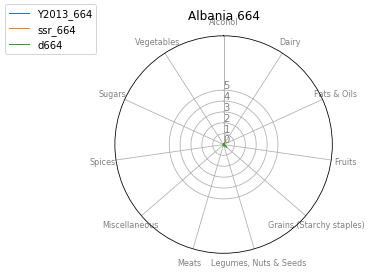

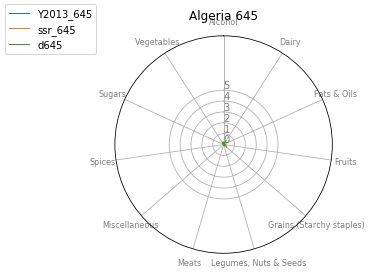

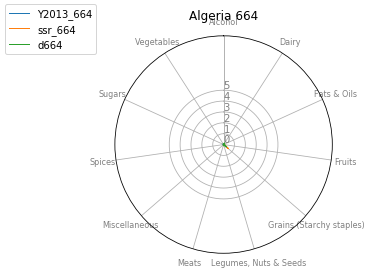

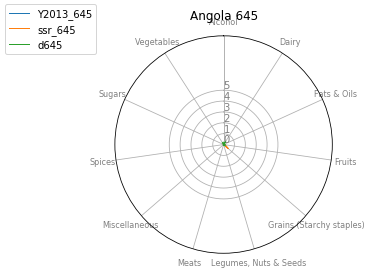

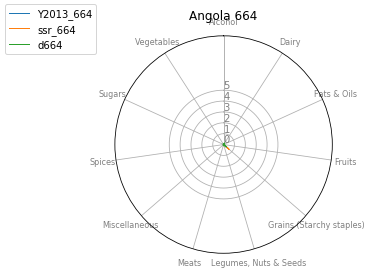

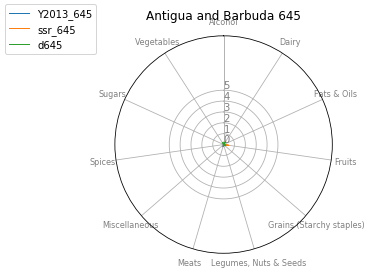

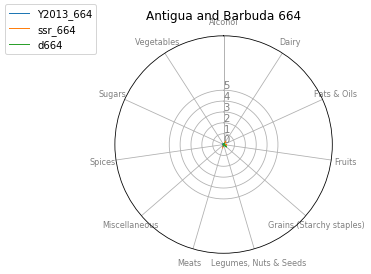

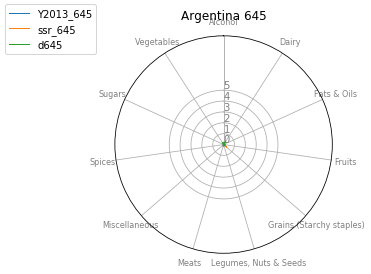

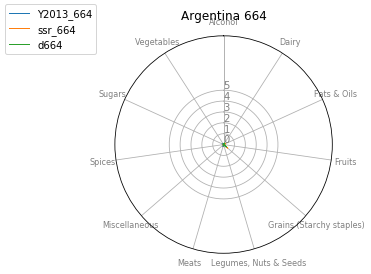

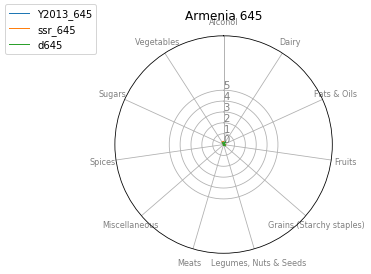

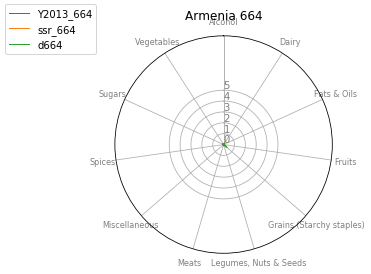

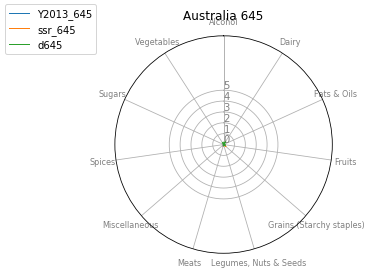

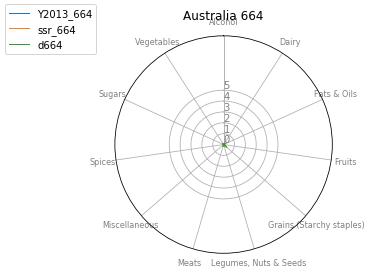

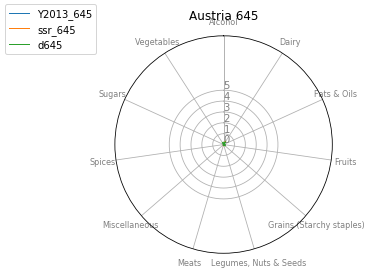

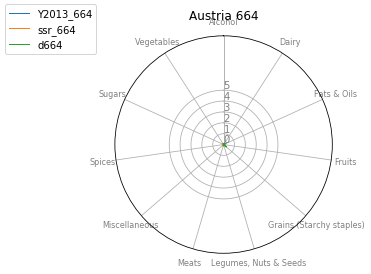

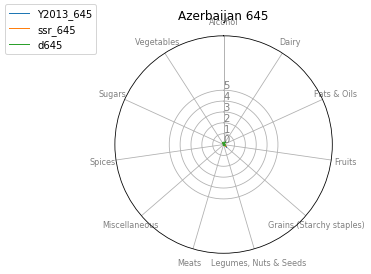

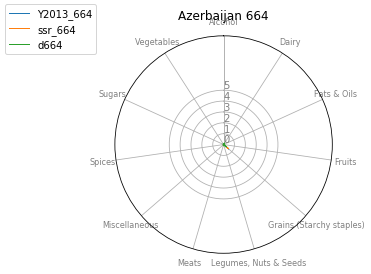

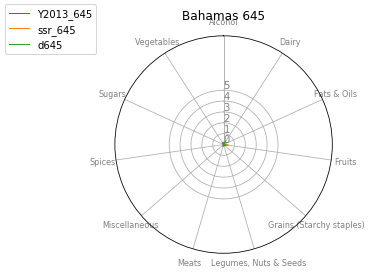

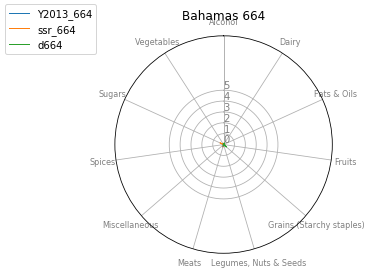

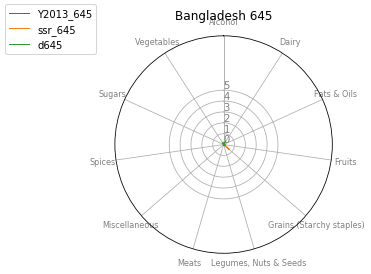

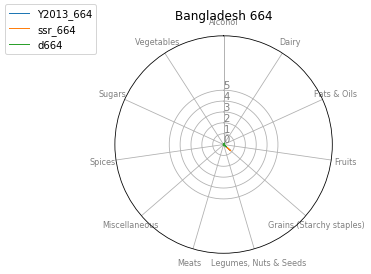

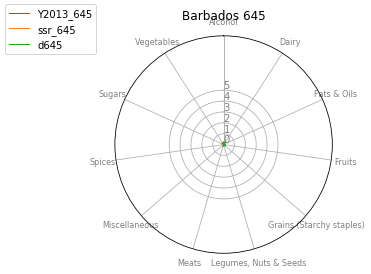

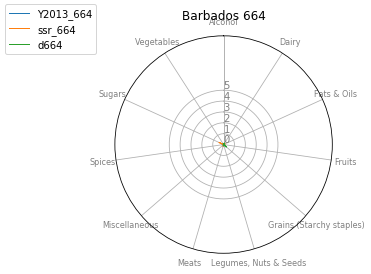

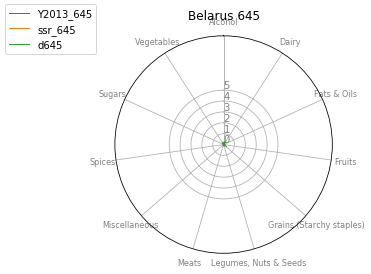

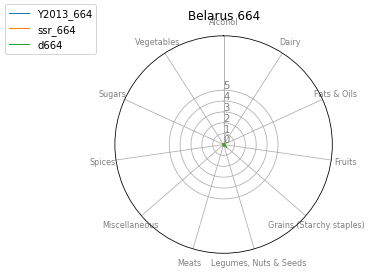

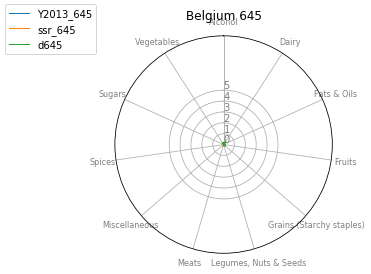

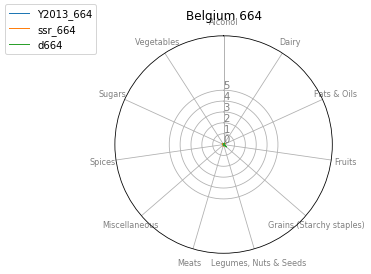

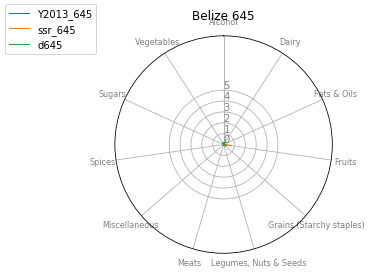

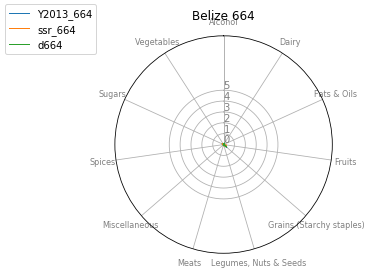

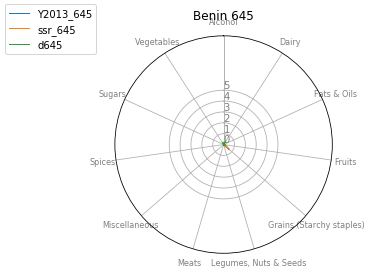

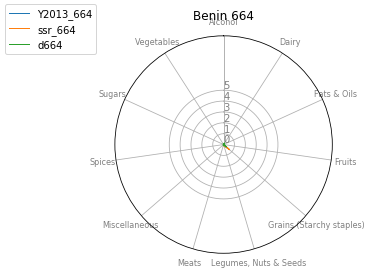

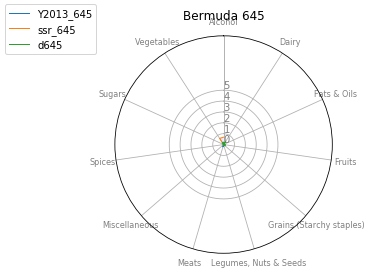

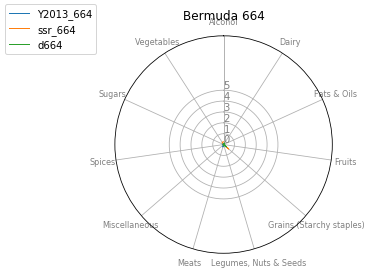

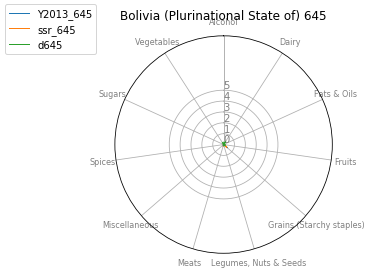

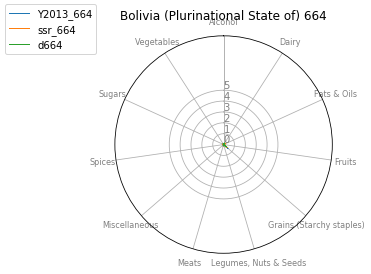

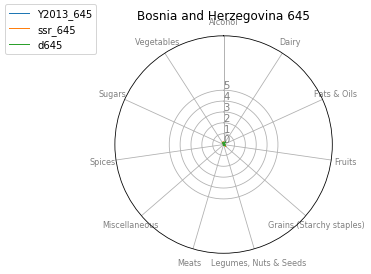

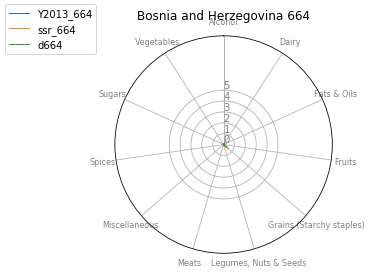

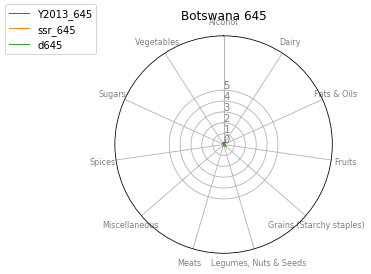

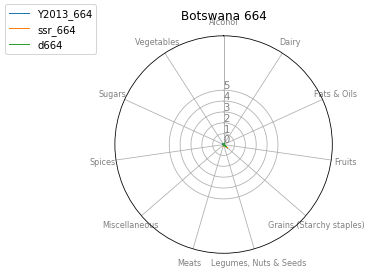

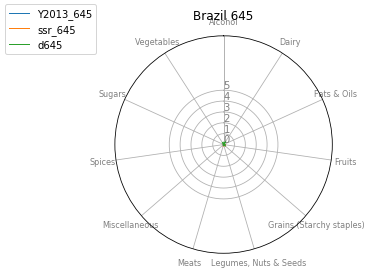

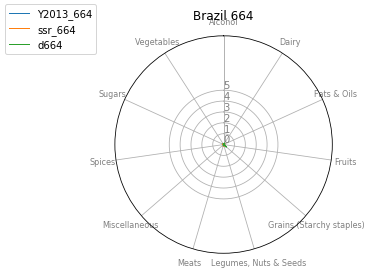

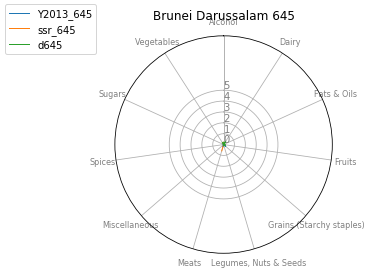

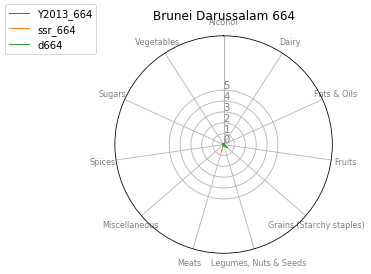

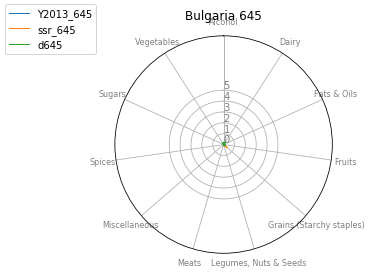

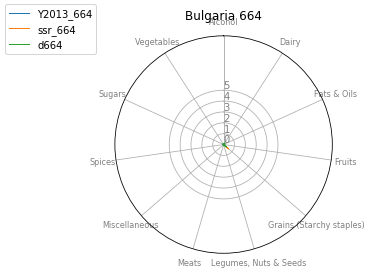

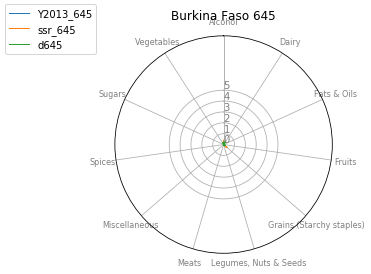

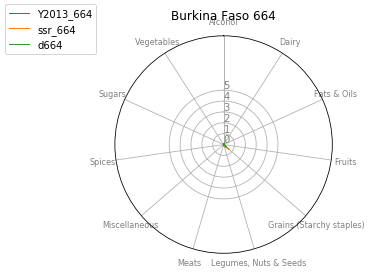

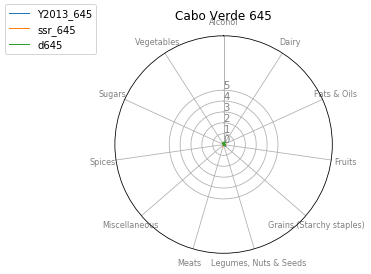

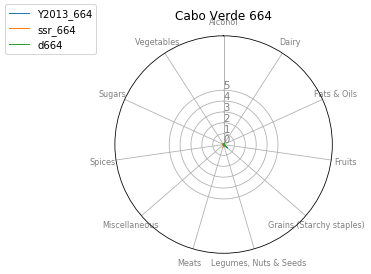

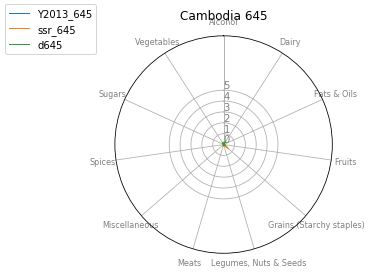

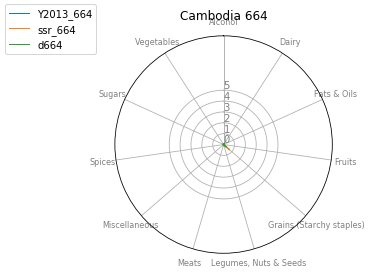

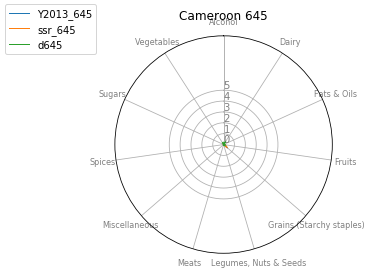

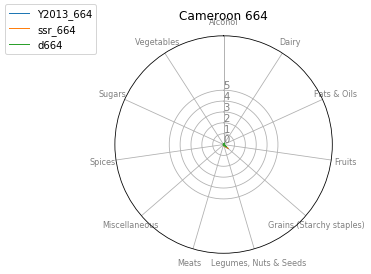

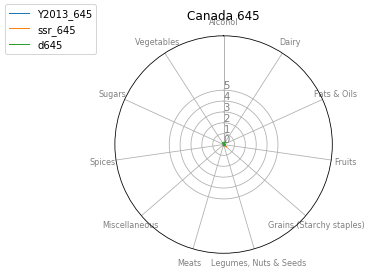

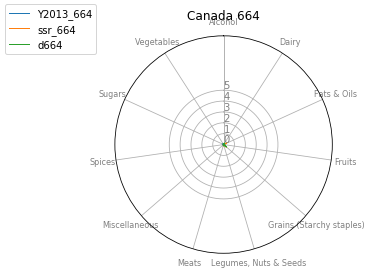

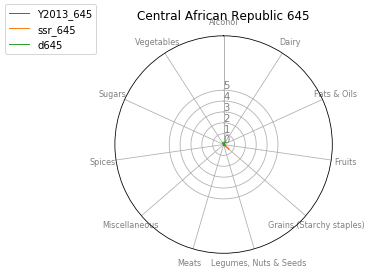

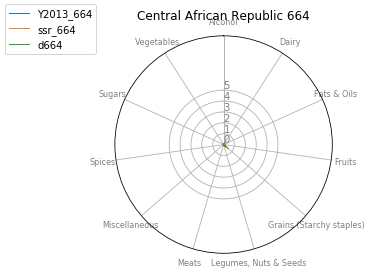

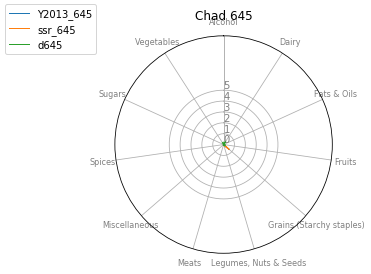

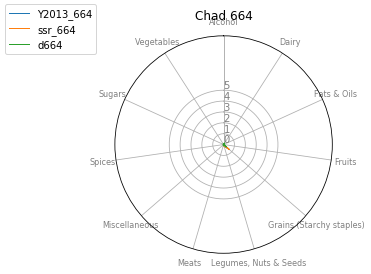

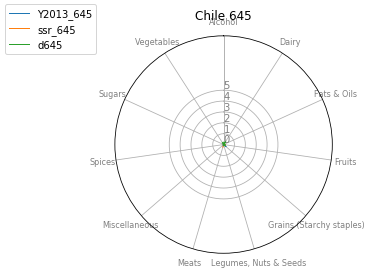

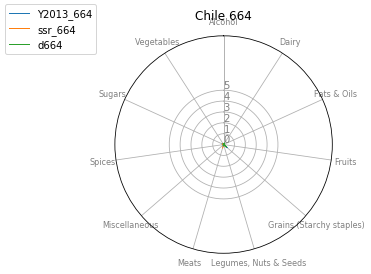

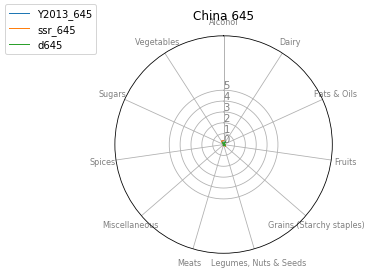

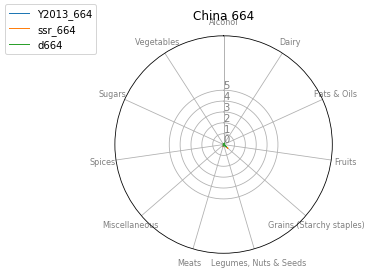

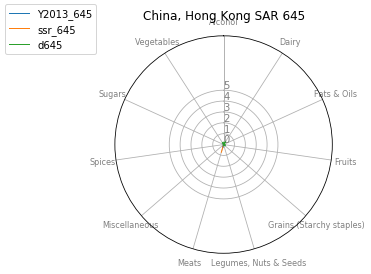

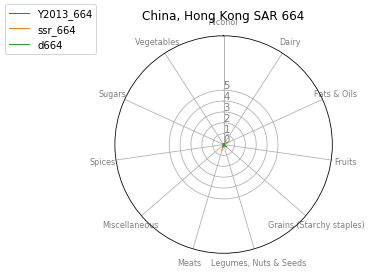

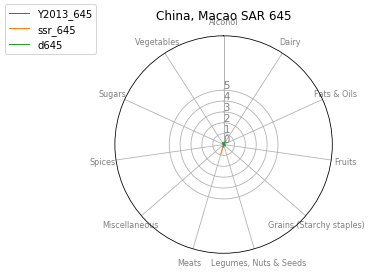

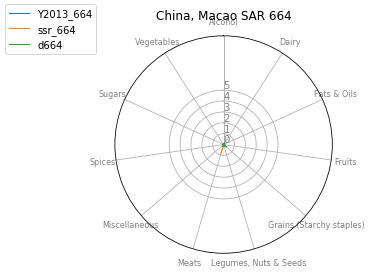

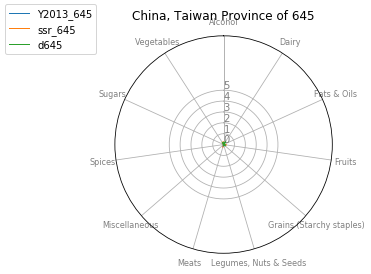

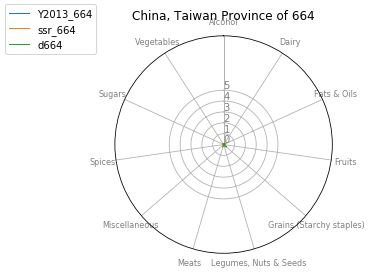

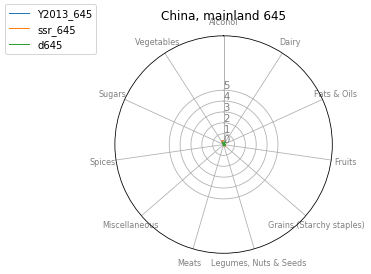

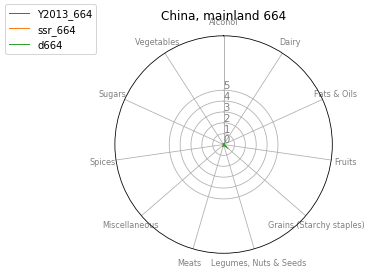

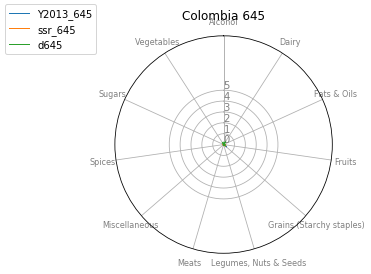

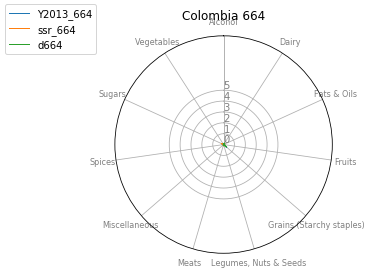

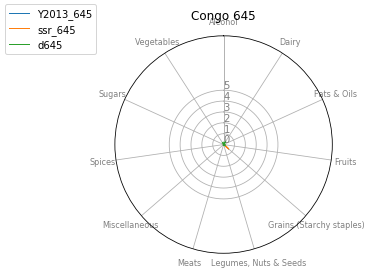

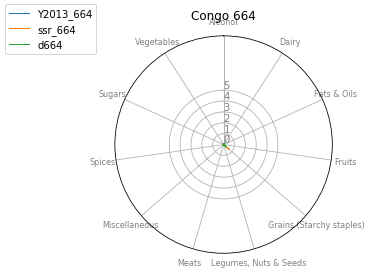

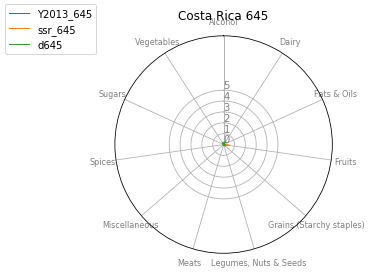

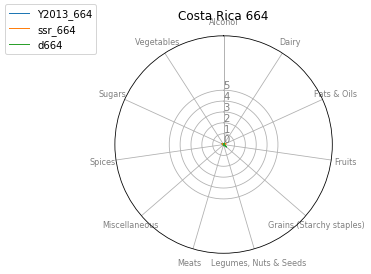

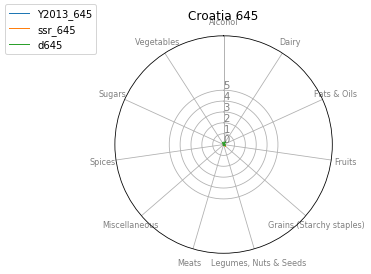

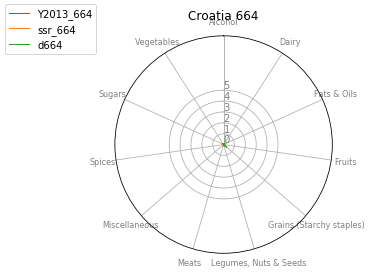

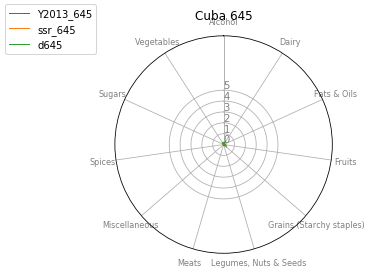

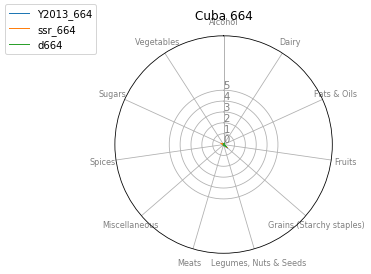

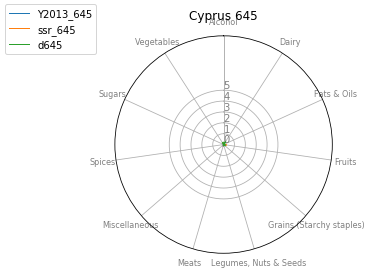

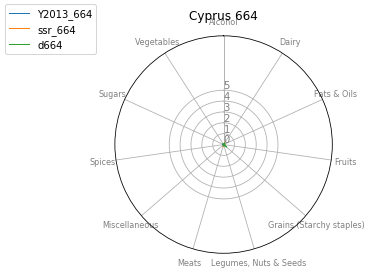

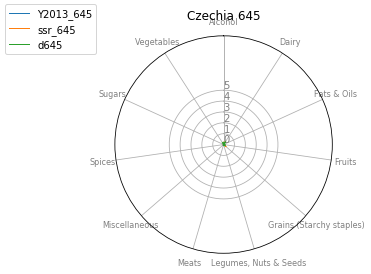

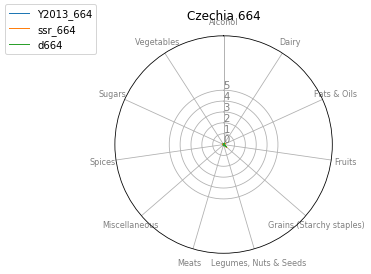

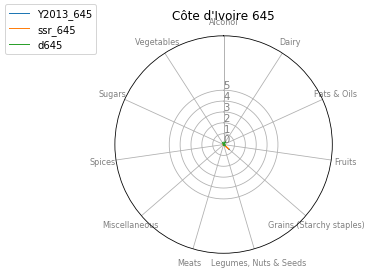

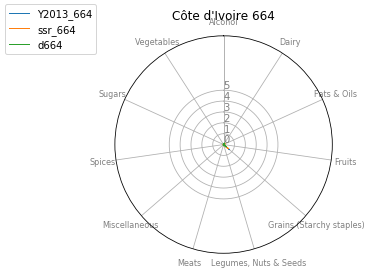

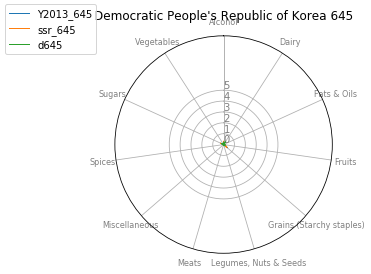

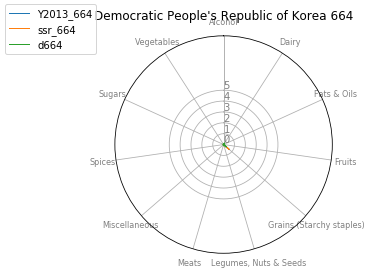

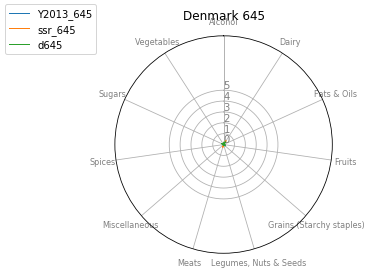

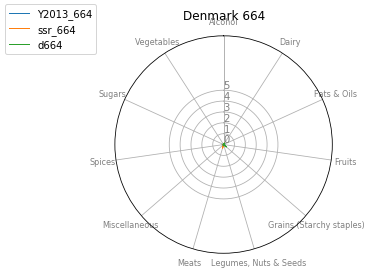

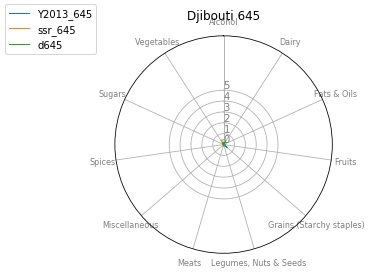

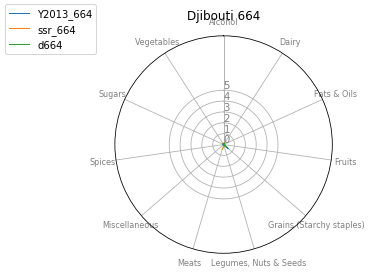

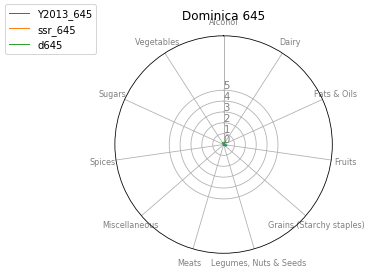

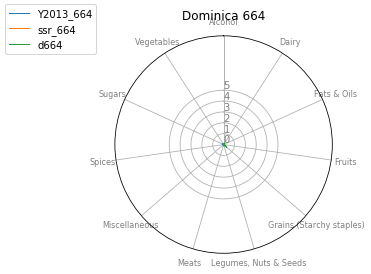

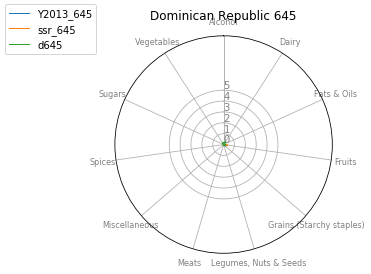

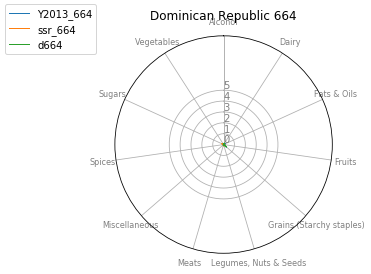

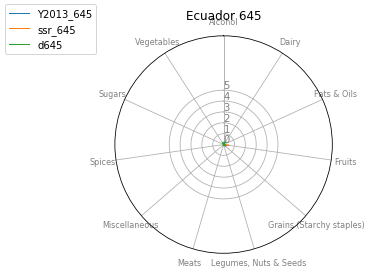

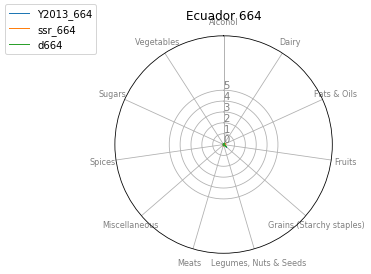

In [30]:
print("Spider analysis")
from math import pi

print("\tSorting data")

data_spider = data_fao_cat.sort_values(by=['area', 'food_group'])


# number of variable
categories=data_spider.food_group.drop_duplicates().values
N = len(categories)

max = data_spider.drop(['area', 'food_group', 'type'], axis=1).max().replace([np.inf, -np.inf], np.nan).dropna().max()
min = data_spider.drop(['area', 'food_group', 'type'], axis=1).min().replace([np.inf, -np.inf], np.nan).dropna().min()

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)    
#angles = [n / float(N) * 2 * pi for n in range(N+1)]
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# loop for each country
for c in data_spider.area.drop_duplicates().values:
    
    print("\t\tCountry " + c)

    # Filtering data by country
    subset = data_spider[data_spider.area == c]    
    
    # loop for each element of fao (diet reference)
    for e in fao_element:
        cols =  [y + "_" + str(e) for y in years_fao_colnames]
        cols.append("d"+ str(e))
        
        # Initialise the spider plot
        fig1 = plt.figure()
        ax = fig1.add_subplot(111, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        #plt.xticks(angles[:-1], categories, color='grey', size=8)
        plt.xticks(angles, categories, color='grey', size=8)
  
        yticks = np.arange(min, max+1, int(max / 5))
        # Draw ylabels
        ax.set_rlabel_position(0)
        #plt.xticks(np.arange(min, max+1, max / 6), color="grey", size=7)
        #plt.yticks(yticks, yticks, color="grey", size=7)
        plt.yticks(yticks, color="grey")
        plt.ylim(0,max+5)

        # Drawing each value to compare into
        for co in cols: 

            values=subset[co].values
            x = values[len(values)-1]

            while len(values) < (len(angles)-1):
                values = np.append(values, [0])

            values = np.append(values, [x])
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=co)
            ax.fill(angles, values, 'b', alpha=0.1)

            if(len(values) != len(angles)):
                angles += angles[:1]

        # Add legend
        ax.set_title(c + " " + str(e))
        fig1.legend(loc='upper left')
        fig1.savefig(path_outputs + "\\spider\\" + str(e) + "-" + c + ".png", dpi=300)

print("\tSuccessful")

['var1', 'var2', 'var3', 'var4', 'var5']
